## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution
3. Surface plots

In [1]:
import sys
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting
from pathlib import Path

In [19]:
dataset = "qpn"
current_release = "Aug_2024"
FS_version = "7.3.2" #"6.0.1" #"7.3.2"
session = "ses-01"

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# imaging derivatives
FS_dir = f"{dataset_dir}/derivatives/freesurfer/v{FS_version}"
FS_DKT_dir = f"{FS_dir}/IDP/{session}/"
DKT_csv = f"{FS_DKT_dir}/dkt.csv"
ASEG_csv = f"{FS_DKT_dir}/aseg.csv"

# UKB encoding of FS fields (DKT + asg) and FS6 vs 7 ROI naming maps
region_field_dir = "/home/nikhil/projects/Parkinsons/region_field_ids/"
ukbb_dkt_ct_fields = f"{region_field_dir}/FS_DKT_UKBB_Fields_ROI_map.csv"
ukbb_aseg_vol_fields = f"{region_field_dir}/FS_ASEG_UKBB_Fields_ROI_map.csv"

# save dirs
save_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/agg_dfs/"
figs_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/figs/"

# Create dirs for results if they don't exist
Path(f"{save_dir}").mkdir(parents=True, exist_ok=True)
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Colormaps

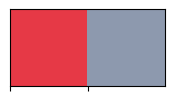

In [13]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

In [14]:
def quick_QC(df, check_cols, min_val, max_val, index_col="participant_id"):
    """Checks for NaNs and out of range outliers """
    
    if index_col in df.columns:
        # check NaNs
        nan_participants = df[df[check_cols].isna().any(axis=1)][index_col].values
        n_nans = len(nan_participants)

        # check range
        outlier_participants = df[df[check_cols].apply(lambda x: (x < min_val) | (x > max_val)).any(axis=1)][index_col].values
        n_outliers = len(outlier_participants)

        print(f"found {n_nans} NaNs and {n_outliers} outliers")
        return list(nan_participants), list(outlier_participants)
    
    else:
        print(f"Provide an index column")
        return None, None

### manifest

In [15]:
manifest_cols = ["participant_id", "visit", "session"]
nipoppy_df = pd.read_csv(manifest_csv)
nipoppy_df = nipoppy_df[manifest_cols] 
nipoppy_participants = nipoppy_df["participant_id"].unique()
n_nipoppy_participants = len(nipoppy_participants)
print(f"nipoppy participants: {n_nipoppy_participants}")
nipoppy_df.head()

nipoppy participants: 306


,participant_id,visit,session
0,MNI0215,MRI_v1,ses-01
1,PD01145,MRI_v1,ses-01
2,MNI0313,MRI_v1,ses-01
3,MNI0476,MRI_v1,ses-01
4,PD01214,MRI_v1,ses-01


### Demographic data

- informs on sex and assigned group at enrollment
- age is dependent on visits and will be grabbed from acq_MRI data

In [38]:
group_col = "enrollment_group"

# useful groups
group_map ={
    "PD   (Parkinson's Disease)/Maladie de Parkinson":"PD", 
    "Healthy control/Contrôle": "control",
    "PPS (Parkinson Plus Syndrome)/PPS (Syndrome Parkinson Plus)": "PPS"
}
useful_groups = ["PD", "control"]

demographics_df = pd.read_csv(demographics_csv)
demographics_df = demographics_df[demographics_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")

# replace column values
demographics_df[group_col] = demographics_df[group_col].replace(group_map)

group_counts = demographics_df.groupby([group_col])["participant_id"].count()
print(f"group counts: {group_counts}")

# filter out useful groups
demographics_df = demographics_df[demographics_df[group_col].isin(useful_groups)]

demographics_df.head()

n_participants: 296
group counts: enrollment_group
PD         208
PPS         15
control     69
Name: participant_id, dtype: int64


,participant_id,redcap_event_name,recruitment_cohort,enrollment_group,sex,education
0,MNI0028,Baseline (Arm 1: C-OPN),QPN,PD,Male/Masculin,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),QPN,PD,Male/Masculin,12.0
2,MNI0058,Baseline (Arm 1: C-OPN),QPN,PD,Male/Masculin,11.0
3,MNI0068,Baseline (Arm 1: C-OPN),QPN,PD,Male/Masculin,11.0
4,MNI0079,Baseline (Arm 1: C-OPN),QPN,PD,Female/Féminin,16.0


### Diagnosis info
- as confirmed later by the clinicians

In [92]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")

index_cols = ["participant_id", "redcap_event_name"]
dx_df = pd.merge(demographics_df[index_cols + ["enrollment_group","sex"]], dx_df, on=index_cols, how="left")

n_participants_with_unconfirmed_dx = dx_df[dx_df["Final impression / Impression finale"].isna()]["participant_id"].nunique()
print(f"participants with unconfirmed dx: {n_participants_with_unconfirmed_dx}")

dx_df.head()

n_participants: 277
participants with unconfirmed dx: 122


,participant_id,redcap_event_name,enrollment_group,sex,Hoehn and Yahr Stage:,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,diagnosis_age
0,MNI0028,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(2) Bilateral involvement without impairment o...,Unsure / Incertain,Uncertain / Incertain,57.13
1,MNI0056,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(3) Bilateral disease: mild to moderate disabi...,Yes / Oui,Meets exclusion criteria / Rencontre des critè...,75.28
2,MNI0058,Baseline (Arm 1: C-OPN),PD,Male/Masculin,"(1) Unilateral involvement only, usually with ...",Yes / Oui,Uncertain / Incertain,56.19
3,MNI0068,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(2) Bilateral involvement without impairment o...,NaN,NaN,61.65
4,MNI0079,Baseline (Arm 1: C-OPN),PD,Female/Féminin,(2) Bilateral involvement without impairment o...,Yes / Oui,Meets criteria for Parkinson's disease / Répon...,45.43


In [95]:
dx_df[dx_df["Final impression / Impression finale"].isna()]

,participant_id,redcap_event_name,enrollment_group,sex,Hoehn and Yahr Stage:,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,diagnosis_age
3,MNI0068,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(2) Bilateral involvement without impairment o...,NaN,NaN,61.65
8,MNI0143,Baseline (Arm 1: C-OPN),control,Male/Masculin,NaN,NaN,NaN,NaN
9,MNI0144,Baseline (Arm 1: C-OPN),control,Female/Féminin,NaN,NaN,NaN,NaN
12,MNI0178,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(2) Bilateral involvement without impairment o...,NaN,NaN,42.30
13,MNI0194,Baseline (Arm 1: C-OPN),control,Female/Féminin,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
270,PD01755,Baseline (Arm 1: C-OPN),control,Female/Féminin,NaN,NaN,NaN,NaN
272,PD01759,Baseline (Arm 1: C-OPN),control,Female/Féminin,NaN,NaN,NaN,NaN
274,MNI0136,Baseline (Arm 1: C-OPN),control,NaN,NaN,NaN,NaN,NaN
275,MNI0605,Baseline (Arm 1: C-OPN),control,NaN,NaN,NaN,NaN,NaN


### UKB - DKT - ASEG fields and names
- These change based on 1) ukbb names 2) FS6 and 3) FS7.

In [41]:
### DKT metadata
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "." + DKT_fields_df["roi"]
# DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

CT_rois = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"])
print("-"*50)
print(f"Loading CT DKT map")
print(f"n_CT_rois: {len(CT_rois)}")
print("-"*50)

lh_CT_rois = DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["hemi_roi"]
rh_CT_rois = DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["hemi_roi"]

# hemi specific dict with FS ROI names
lh_CT_roi_dict = dict(zip(lh_CT_rois,CT_rois))
rh_CT_roi_dict = dict(zip(rh_CT_rois,CT_rois))

### ASEG metadata
ASEG_fields_df = pd.read_csv(ukbb_aseg_vol_fields)
left_hemi_suffixes = ["Left-","lh","left-"]
right_hemi_suffixes = ["Right-","rh","right-"]

roi_naming_version = FS_version.split(".",1)[0]
print(f"Loading vol ASEG map")
print(f"**roi_naming_version: {roi_naming_version}**")

roi_col = f"FS{roi_naming_version}_roi"
hemi_col = f"FS{roi_naming_version}_hemi"

vol_ROIs = ASEG_fields_df[roi_col].values
print(f"n_vol_ROIs: {len(vol_ROIs)}")
vol_hemis = ASEG_fields_df[hemi_col].values
vol_hemi_counts = ASEG_fields_df[hemi_col].value_counts()
print(f"n_rois per hemi: {vol_hemi_counts}")

lh_vol_rois = list(ASEG_fields_df[ASEG_fields_df[hemi_col].isin(left_hemi_suffixes)][roi_col].values)
rh_vol_rois = list(ASEG_fields_df[ASEG_fields_df[hemi_col].isin(right_hemi_suffixes)][roi_col].values)
global_vol_rois = list(ASEG_fields_df[ASEG_fields_df[hemi_col].isna()][roi_col].dropna().values)


print(f"n_lh_ASEG_rois: {len(lh_vol_rois)}")
print(f"n_rh_ASEG_rois: {len(rh_vol_rois)}")
print(f"n_global_ASEG_rois: {len(global_vol_rois)}")
print("-"*50)

ASEG_fields_df[hemi_col] = ASEG_fields_df[hemi_col].fillna("")
ASEG_fields_df["hemi_roi"] = ASEG_fields_df[hemi_col] + ASEG_fields_df[roi_col] # delimiter is part of the hemi col is present
lh_hemi_ASEG_rois = ASEG_fields_df[ASEG_fields_df[hemi_col].isin(left_hemi_suffixes)]["hemi_roi"]
rh_hemi_ASEG_rois = ASEG_fields_df[ASEG_fields_df[hemi_col].isin(right_hemi_suffixes)]["hemi_roi"]

lh_hemi_ASEG_roi_dict = dict(zip(lh_hemi_ASEG_rois,lh_vol_rois))
rh_hemi_ASEG_roi_dict = dict(zip(rh_hemi_ASEG_rois,rh_vol_rois))

ASEG_fields_df.head()

--------------------------------------------------
Loading CT DKT map
n_CT_rois: 31
--------------------------------------------------
Loading vol ASEG map
**roi_naming_version: 7**
n_vol_ROIs: 67
n_rois per hemi: FS7_hemi
Left-     16
Right-    16
lh         3
rh         3
Name: count, dtype: int64
n_lh_ASEG_rois: 19
n_rh_ASEG_rois: 19
n_global_ASEG_rois: 27
--------------------------------------------------


,Field ID,Description,metric,ukbb_roi,ukbb_hemi,FS6_roi,FS6_hemi,FS7_roi,FS7_hemi,hemi_roi
0,26523.0,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,NaN,3rd-Ventricle,NaN,3rd-Ventricle,,3rd-Ventricle
1,26524.0,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,NaN,4th-Ventricle,NaN,4th-Ventricle,,4th-Ventricle
2,26525.0,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,NaN,5th-Ventricle,NaN,5th-Ventricle,,5th-Ventricle
3,26564.0,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Accumbens-area,Left-,Accumbens-area,Left-,Left-Accumbens-area
4,26595.0,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Accumbens-area,Right-,Accumbens-area,Right-,Right-Accumbens-area


### Read DKT data

In [71]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df.head()

,participant_id,lh.caudalanteriorcingulate,lh.caudalmiddlefrontal,lh.cuneus,lh.entorhinal,lh.fusiform,lh.inferiorparietal,lh.inferiortemporal,lh.isthmuscingulate,lh.lateraloccipital,...,rh.precuneus,rh.rostralanteriorcingulate,rh.rostralmiddlefrontal,rh.superiorfrontal,rh.superiorparietal,rh.superiortemporal,rh.supramarginal,rh.transversetemporal,rh.insula,rh.temporalpole
0,sub-MNI0028,2.495,2.365,1.781,3.372,2.821,2.232,2.785,2.061,1.949,...,2.375,2.484,2.151,2.448,2.025,2.732,2.305,2.302,2.981,NaN
1,sub-MNI0056,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.100,2.075,...,2.359,2.358,2.111,2.445,2.400,2.595,2.364,1.990,2.586,NaN
2,sub-MNI0058,2.597,2.626,1.892,3.349,2.956,2.457,2.774,2.364,2.008,...,2.566,2.584,2.395,2.545,2.352,2.357,2.597,1.975,1.555,NaN
3,sub-MNI0068,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.004,2.000,...,2.170,2.698,2.169,2.274,1.964,2.516,2.232,2.130,2.888,NaN
4,sub-MNI0079,2.418,2.654,1.875,3.616,2.765,2.504,2.734,2.185,2.291,...,2.506,2.461,2.278,2.647,2.298,2.794,2.668,2.296,3.117,NaN


In [72]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df["participant_id"] = CT_DKT_df["participant_id"].str.split("-", expand=True)[1]

FS_participants = list(CT_DKT_df["participant_id"].unique())
print(f"n_FS_participants: {len(FS_participants)}")

# Check ROI names 
expected_cols = set(DKT_fields_df["hemi_roi"].unique())
data_cols = set(CT_DKT_df.columns)
if len(expected_cols - data_cols) == 0:
    print("all expected CT DKT ROI names are in the dataframe")
else:
    extra_schema_cols = data_cols - expected_cols
    print(f"missing ROI names in the dataframe: {extra_schema_cols}")

unknown_CT_DKT_cols = set(CT_DKT_df.columns) - set(DKT_fields_df["hemi_roi"].values) - set(["participant_id"])
if len(unknown_CT_DKT_cols) > 0:
    print(f"found extra columns in CT DKT: {unknown_CT_DKT_cols}, dropping extra columns...")
    CT_DKT_df = CT_DKT_df.drop(columns=unknown_CT_DKT_cols)

n_FS_participants: 295
all expected CT DKT ROI names are in the dataframe
found extra columns in CT DKT: {'rh.temporalpole'}, dropping extra columns...


### Merge with demographics

In [73]:
## Merge with demographics
startification_col = "enrollment_group"
demo_cols = ["participant_id","sex", startification_col]
CT_DKT_df = pd.merge(CT_DKT_df,dx_df[demo_cols],on="participant_id",how="left")

participants_per_group = CT_DKT_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants per group: {participants_per_group}")

CT_DKT_df.head()

participants per group: enrollment_group
PD         206
control     68
Name: participant_id, dtype: int64


,participant_id,lh.caudalanteriorcingulate,lh.caudalmiddlefrontal,lh.cuneus,lh.entorhinal,lh.fusiform,lh.inferiorparietal,lh.inferiortemporal,lh.isthmuscingulate,lh.lateraloccipital,...,rh.rostralanteriorcingulate,rh.rostralmiddlefrontal,rh.superiorfrontal,rh.superiorparietal,rh.superiortemporal,rh.supramarginal,rh.transversetemporal,rh.insula,sex,enrollment_group
0,MNI0028,2.495,2.365,1.781,3.372,2.821,2.232,2.785,2.061,1.949,...,2.484,2.151,2.448,2.025,2.732,2.305,2.302,2.981,Male/Masculin,PD
1,MNI0056,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.100,2.075,...,2.358,2.111,2.445,2.400,2.595,2.364,1.990,2.586,Male/Masculin,PD
2,MNI0058,2.597,2.626,1.892,3.349,2.956,2.457,2.774,2.364,2.008,...,2.584,2.395,2.545,2.352,2.357,2.597,1.975,1.555,Male/Masculin,PD
3,MNI0068,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.004,2.000,...,2.698,2.169,2.274,1.964,2.516,2.232,2.130,2.888,Male/Masculin,PD
4,MNI0079,2.418,2.654,1.875,3.616,2.765,2.504,2.734,2.185,2.291,...,2.461,2.278,2.647,2.298,2.794,2.668,2.296,3.117,Female/Féminin,PD


### Split DKT data into left and right hemisphere

In [74]:
save_results = True

lh_CT_DKT_df = CT_DKT_df[list(lh_CT_rois) + demo_cols].copy()
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = CT_DKT_df[list(rh_CT_rois) + demo_cols].copy()
rh_CT_DKT_df["hemi"] = "rh"

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_CT_roi_dict)
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_CT_roi_dict)

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

if save_results:
    CT_DKT_df.to_csv(f"{save_dir}/CT_DKT_df.csv")
    
CT_DKT_df.head()

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,rostralmiddlefrontal,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,participant_id,sex,enrollment_group,hemi
0,2.495,2.365,1.781,3.372,2.821,2.232,2.785,3.230,2.061,1.949,...,2.217,2.465,1.987,2.747,2.245,2.042,MNI0028,Male/Masculin,PD,lh
1,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.612,2.100,2.075,...,2.181,2.533,2.464,2.466,2.275,2.057,MNI0056,Male/Masculin,PD,lh
2,2.597,2.626,1.892,3.349,2.956,2.457,2.774,3.116,2.364,2.008,...,2.462,2.726,2.275,3.036,2.474,2.311,MNI0058,Male/Masculin,PD,lh
3,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.898,2.004,2.000,...,2.184,2.344,1.917,2.355,2.089,1.903,MNI0068,Male/Masculin,PD,lh
4,2.418,2.654,1.875,3.616,2.765,2.504,2.734,3.343,2.185,2.291,...,2.359,2.672,2.356,2.806,2.534,2.068,MNI0079,Female/Féminin,PD,lh


### Quick QC before plots

In [75]:
check_cols = lh_CT_roi_dict.values()
min_val = 0
max_val = 10
nan_participants, outlier_participants = quick_QC(CT_DKT_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"removing {len(remove_participants)} participants: {remove_participants}")
CT_DKT_df = CT_DKT_df[~CT_DKT_df["participant_id"].isin(remove_participants)]

found 1 NaNs and 0 outliers
removing 1 participants: ['PD00457']


### Plot DKT

n_participants: 294
participants_per_group: enrollment_group
PD         205
control     68
Name: participant_id, dtype: int64


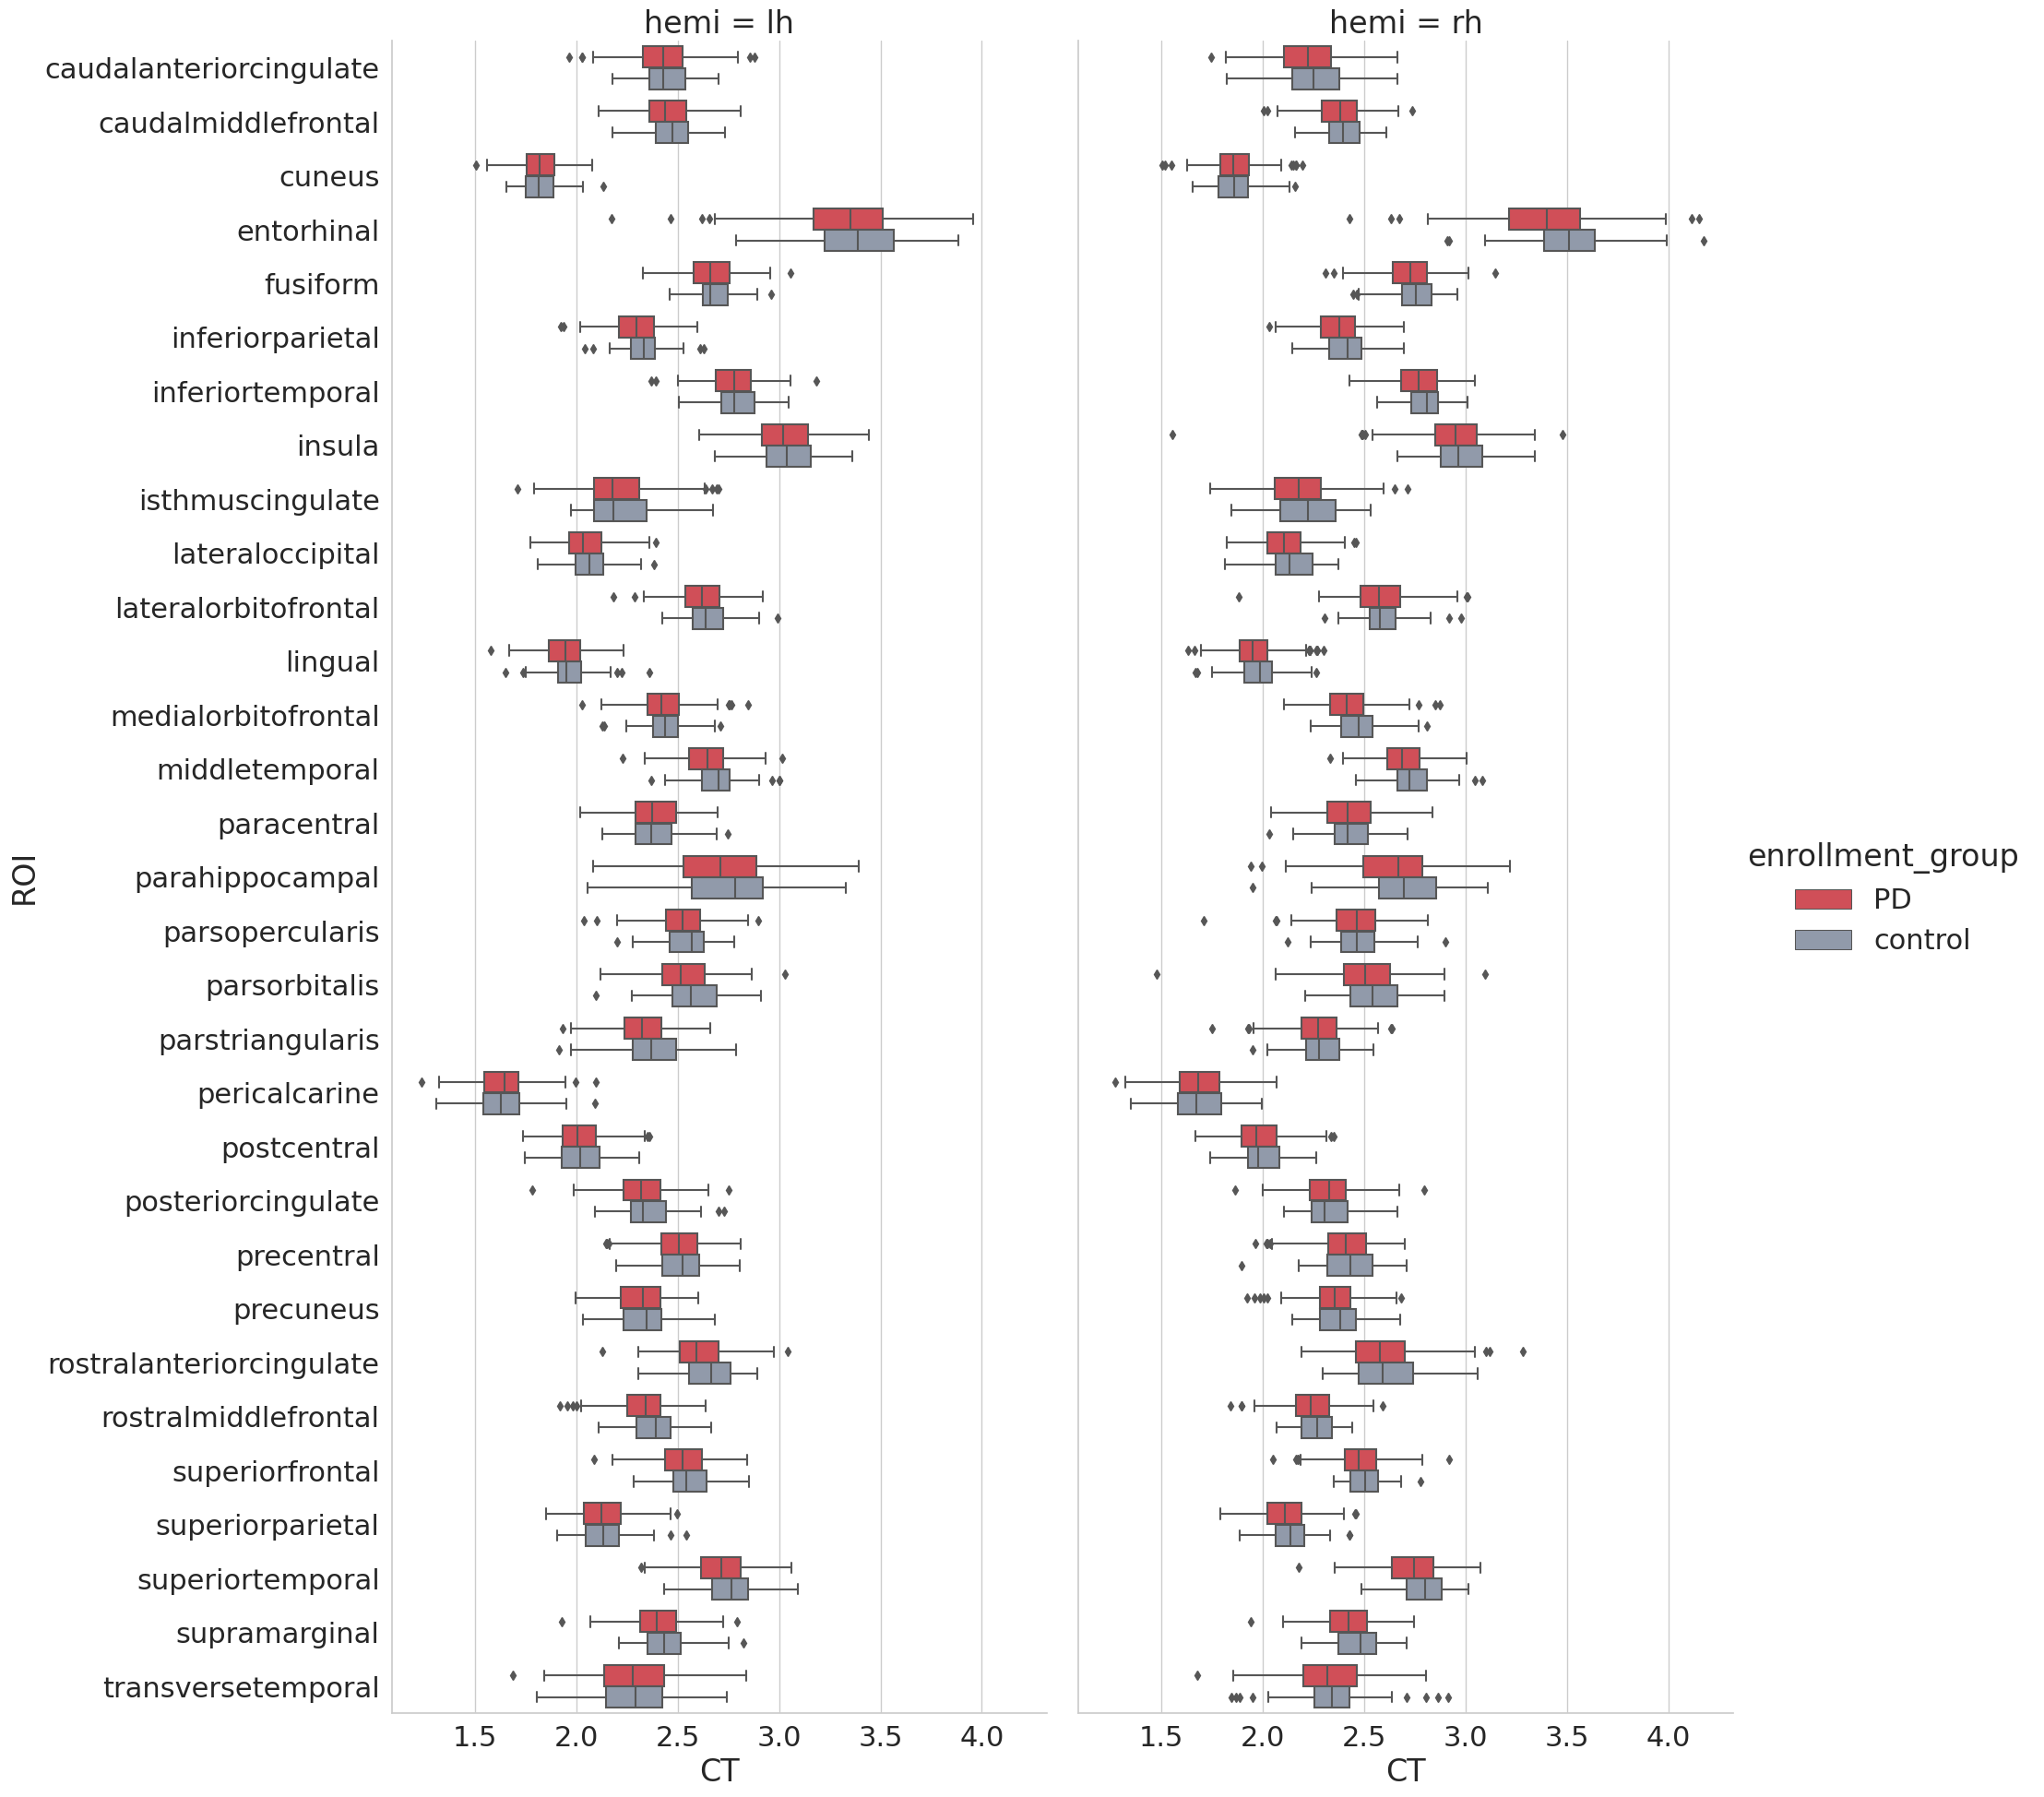

In [76]:
save_fig = False

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")
participants_per_group = plot_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")

sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue=startification_col, col="hemi",kind="box",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Save CT DKT data

In [90]:
save_agg_CT_df = True

if save_agg_CT_df:
    save_file = f"{save_dir}/CT_DKT_df.csv"
    print(f"Saving CT_DKT_df to {save_file}")
    CT_DKT_df.to_csv(save_file, index=False)

CT_DKT_df.head()

Saving CT_DKT_df to /home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/qpn/Aug_2024/agg_dfs//CT_DKT_df.csv


,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,rostralmiddlefrontal,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,participant_id,sex,enrollment_group,hemi
0,2.495,2.365,1.781,3.372,2.821,2.232,2.785,3.230,2.061,1.949,...,2.217,2.465,1.987,2.747,2.245,2.042,MNI0028,Male/Masculin,PD,lh
1,2.299,2.486,1.800,2.979,2.575,2.347,2.648,2.612,2.100,2.075,...,2.181,2.533,2.464,2.466,2.275,2.057,MNI0056,Male/Masculin,PD,lh
2,2.597,2.626,1.892,3.349,2.956,2.457,2.774,3.116,2.364,2.008,...,2.462,2.726,2.275,3.036,2.474,2.311,MNI0058,Male/Masculin,PD,lh
3,2.335,2.236,1.506,3.084,2.560,2.050,2.578,2.898,2.004,2.000,...,2.184,2.344,1.917,2.355,2.089,1.903,MNI0068,Male/Masculin,PD,lh
4,2.418,2.654,1.875,3.616,2.765,2.504,2.734,3.343,2.185,2.291,...,2.359,2.672,2.356,2.806,2.534,2.068,MNI0079,Female/Féminin,PD,lh


### Volumetric measures

In [81]:
vol_ASEG_df = pd.read_csv(ASEG_csv)

vol_ASEG_df["participant_id"] = vol_ASEG_df["participant_id"].str.split("-", expand=True)[1]

FS_participants = list(vol_ASEG_df["participant_id"].unique())
print(f"n_FS_participants: {len(FS_participants)}")

# Check the FS version and corresponding ROI

expected_cols = set(ASEG_fields_df["hemi_roi"].dropna().unique())
data_cols = set(vol_ASEG_df.columns)

if len(expected_cols - data_cols) == 0:
    print("all expected CT DKT ROI names are in the dataframe")
else:
    extra_schema_cols = expected_cols - data_cols
    print(f"missing columns in vol ASEG dataframe: {extra_schema_cols}")


unknown_vol_ASEG_cols = data_cols - expected_cols - set(["participant_id"])
if len(unknown_vol_ASEG_cols) > 0:
    print(f"found extra columns: {unknown_vol_ASEG_cols}")


n_FS_participants: 295
all expected CT DKT ROI names are in the dataframe


### Merge with demographics

In [82]:
vol_ASEG_df = pd.merge(vol_ASEG_df,dx_df,on="participant_id",how="left")
vol_ASEG_df.head()

,participant_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol,redcap_event_name,enrollment_group,sex,Hoehn and Yahr Stage:,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,diagnosis_age
0,MNI0028,11538.1,228.9,18843.2,54138.4,7875.5,4029.1,4663.7,2000.3,1360.3,...,4,7,1.697395e+06,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(2) Bilateral involvement without impairment o...,Unsure / Incertain,Uncertain / Incertain,57.13
1,MNI0056,30555.6,1607.7,13703.8,48542.0,6155.8,3487.1,4369.6,1823.3,2976.9,...,11,26,1.824266e+06,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(3) Bilateral disease: mild to moderate disabi...,Yes / Oui,Meets exclusion criteria / Rencontre des critè...,75.28
2,MNI0058,5535.2,414.3,13783.8,49483.3,8159.6,3600.7,5053.6,2039.0,1429.2,...,35,44,1.650578e+06,Baseline (Arm 1: C-OPN),PD,Male/Masculin,"(1) Unilateral involvement only, usually with ...",Yes / Oui,Uncertain / Incertain,56.19
3,MNI0068,10275.8,938.8,12266.4,54126.8,6451.4,3012.0,3665.1,1439.1,1348.8,...,5,11,1.498812e+06,Baseline (Arm 1: C-OPN),PD,Male/Masculin,(2) Bilateral involvement without impairment o...,NaN,NaN,61.65
4,MNI0079,4671.2,214.3,16150.4,53101.7,7972.0,3534.6,4085.1,1915.6,952.4,...,9,15,1.537383e+06,Baseline (Arm 1: C-OPN),PD,Female/Féminin,(2) Bilateral involvement without impairment o...,Yes / Oui,Meets criteria for Parkinson's disease / Répon...,45.43


### Split bilateral volumetric data into left and right hemisphere

In [83]:
save_results = False

lh_vol_ASEG_df = vol_ASEG_df[list(lh_hemi_ASEG_rois) + demo_cols].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[list(rh_hemi_ASEG_rois) + demo_cols].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[global_vol_rois + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_hemi_ASEG_roi_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_hemi_ASEG_roi_dict)
# global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=global_ASEG_roi_dict)

bilateral_vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

if save_results:
    bilateral_vol_ASEG_df.to_csv(f"{save_dir}/bilateral_vol_ASEG_df.csv")
    global_vol_ASEG_df.to_csv(f"{save_dir}/global_vol_ASEG_df.csv")

bilateral_vol_ASEG_df.head()

,Accumbens-area,Amygdala,Caudate,Cerebellum-Cortex,Cerebellum-White-Matter,CerebralWhiteMatter,Cortex,Hippocampus,Inf-Lat-Vent,Lateral-Ventricle,...,VentralDC,choroid-plexus,vessel,SurfaceHoles,WM-hypointensities,non-WM-hypointensities,participant_id,sex,enrollment_group,hemi
0,579.6,1668.4,4029.1,54138.4,18843.2,283456.5,234057.247054,3934.9,228.9,11538.1,...,4452.1,677.5,55.8,3,0.0,0.0,MNI0028,Male/Masculin,PD,lh
1,263.9,1592.1,3487.1,48542.0,13703.8,255251.5,232637.328935,3730.1,1607.7,30555.6,...,3841.0,974.1,48.7,15,0.0,0.0,MNI0056,Male/Masculin,PD,lh
2,711.8,1827.6,3600.7,49483.3,13783.8,273383.5,266523.290741,5074.8,414.3,5535.2,...,4251.3,567.4,14.4,9,0.0,0.0,MNI0058,Male/Masculin,PD,lh
3,562.6,1818.5,3012.0,54126.8,12266.4,218817.5,210987.112993,3842.7,938.8,10275.8,...,3567.8,572.8,9.4,6,0.0,0.0,MNI0068,Male/Masculin,PD,lh
4,567.5,1609.3,3534.6,53101.7,16150.4,236617.0,230780.196816,4146.3,214.3,4671.2,...,4035.0,272.5,108.8,6,0.0,0.0,MNI0079,Female/Féminin,PD,lh


### Quick QC before plots

In [84]:
check_cols = lh_hemi_ASEG_roi_dict.values()
min_val = 0
max_val = 3000000
nan_participants, outlier_participants = quick_QC(bilateral_vol_ASEG_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"Bilateral regions: removing {len(remove_participants)} participants")
bilateral_vol_ASEG_df = bilateral_vol_ASEG_df[~bilateral_vol_ASEG_df["participant_id"].isin(remove_participants)]

check_cols = global_vol_rois
nan_participants, outlier_participants = quick_QC(global_vol_ASEG_df, check_cols, min_val, max_val, index_col="participant_id")
remove_participants = list(set(nan_participants + outlier_participants))

print(f"Global regions: removing {len(remove_participants)} participants")
global_vol_ASEG_df = global_vol_ASEG_df[~global_vol_ASEG_df["participant_id"].isin(remove_participants)]

found 0 NaNs and 0 outliers
Bilateral regions: removing 0 participants
found 0 NaNs and 0 outliers
Global regions: removing 0 participants


### Plot ASEG
- hemi 
- global

n_participants: 295
participants_per_group: enrollment_group
PD         206
control     68
Name: participant_id, dtype: int64


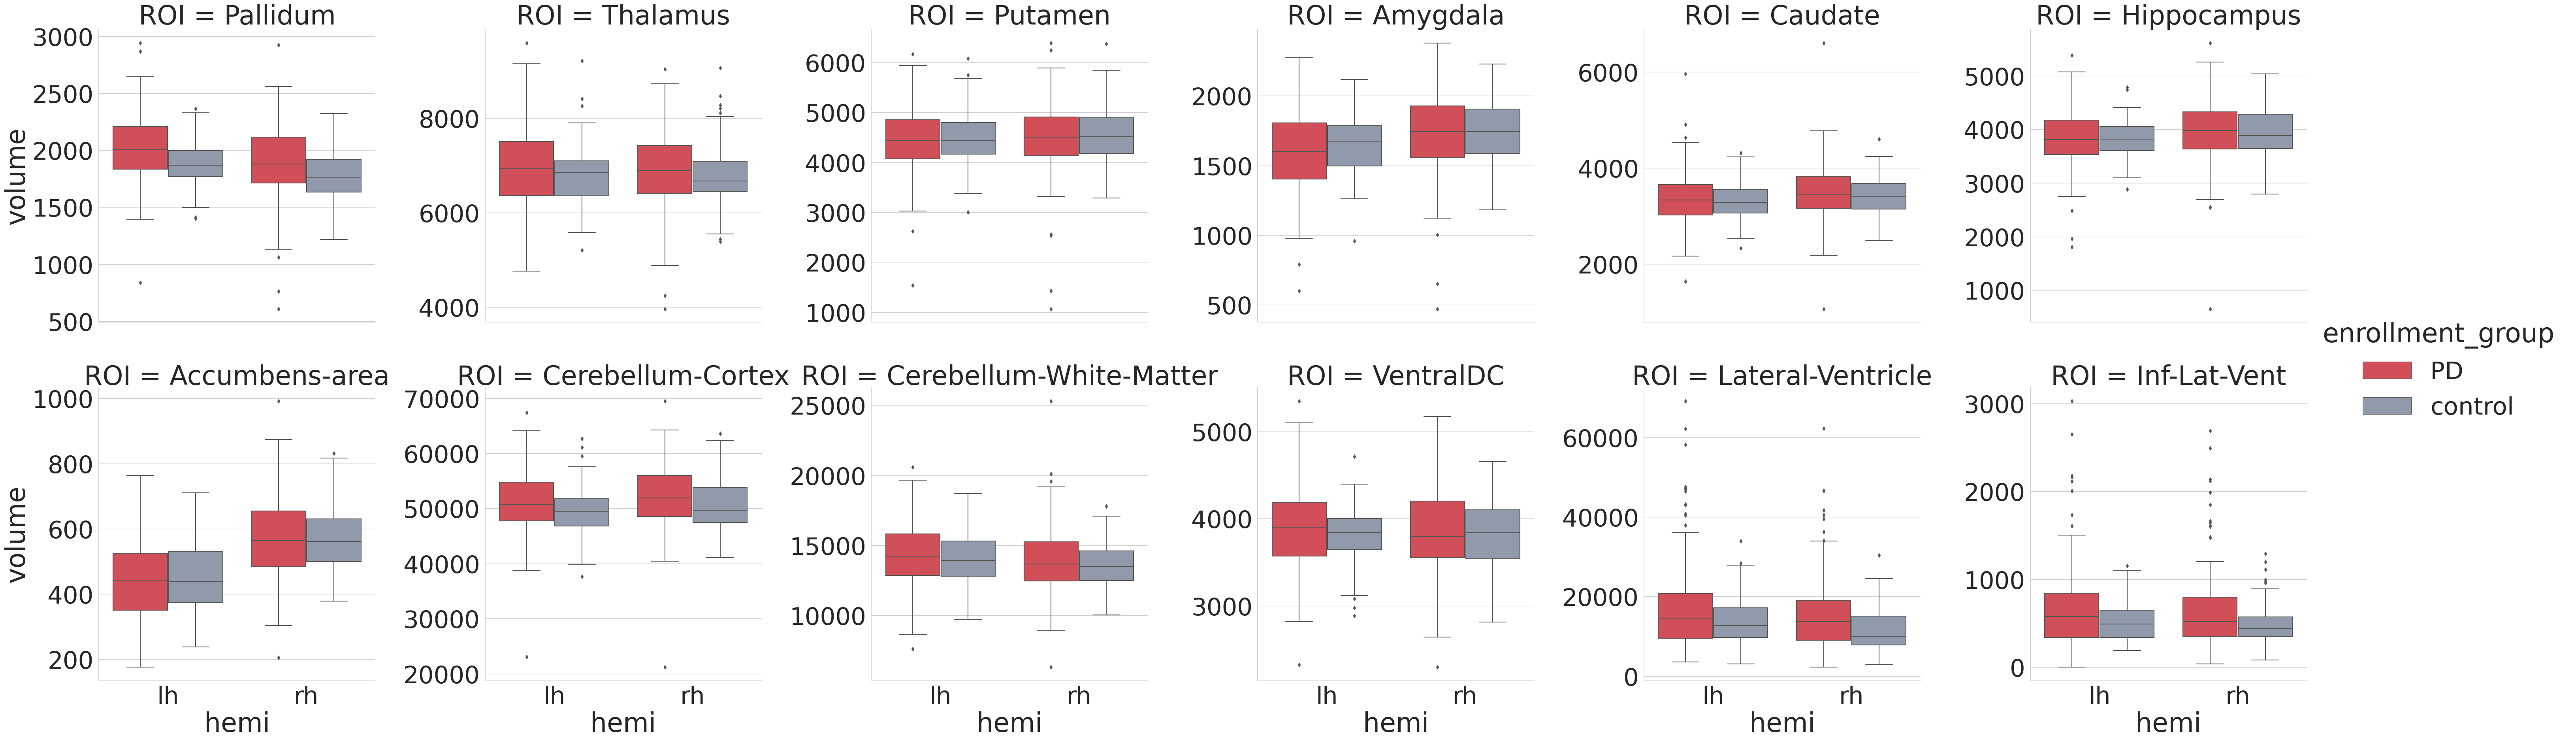

In [85]:
save_fig = False

# Rename global regions for brevity
plot_renaming_dict = {"Thalamus-Proper":"Thalamus"} #FSv6 --> FSv7
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=plot_renaming_dict)


vol_ASEG_df_melt = bilateral_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")
participants_per_group = plot_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue=startification_col, col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_bilateral.png")

### Save hemi aseg vols

In [86]:
save_agg_aseg_df = True

if save_agg_aseg_df:
    save_file = f"{save_dir}/bilateral_vol_ASEG_df.csv"
    print(f"Saving aseg_DKT_df to {save_file}")
    bilateral_vol_ASEG_df.to_csv(save_file, index=False)

bilateral_vol_ASEG_df.head()

Saving aseg_DKT_df to /home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/qpn/Aug_2024/agg_dfs//bilateral_vol_ASEG_df.csv


,Accumbens-area,Amygdala,Caudate,Cerebellum-Cortex,Cerebellum-White-Matter,CerebralWhiteMatter,Cortex,Hippocampus,Inf-Lat-Vent,Lateral-Ventricle,...,VentralDC,choroid-plexus,vessel,SurfaceHoles,WM-hypointensities,non-WM-hypointensities,participant_id,sex,enrollment_group,hemi
0,579.6,1668.4,4029.1,54138.4,18843.2,283456.5,234057.247054,3934.9,228.9,11538.1,...,4452.1,677.5,55.8,3,0.0,0.0,MNI0028,Male/Masculin,PD,lh
1,263.9,1592.1,3487.1,48542.0,13703.8,255251.5,232637.328935,3730.1,1607.7,30555.6,...,3841.0,974.1,48.7,15,0.0,0.0,MNI0056,Male/Masculin,PD,lh
2,711.8,1827.6,3600.7,49483.3,13783.8,273383.5,266523.290741,5074.8,414.3,5535.2,...,4251.3,567.4,14.4,9,0.0,0.0,MNI0058,Male/Masculin,PD,lh
3,562.6,1818.5,3012.0,54126.8,12266.4,218817.5,210987.112993,3842.7,938.8,10275.8,...,3567.8,572.8,9.4,6,0.0,0.0,MNI0068,Male/Masculin,PD,lh
4,567.5,1609.3,3534.6,53101.7,16150.4,236617.0,230780.196816,4146.3,214.3,4671.2,...,4035.0,272.5,108.8,6,0.0,0.0,MNI0079,Female/Féminin,PD,lh


n_participants: 295
participants_per_group: enrollment_group
PD         206
control     68
Name: participant_id, dtype: int64


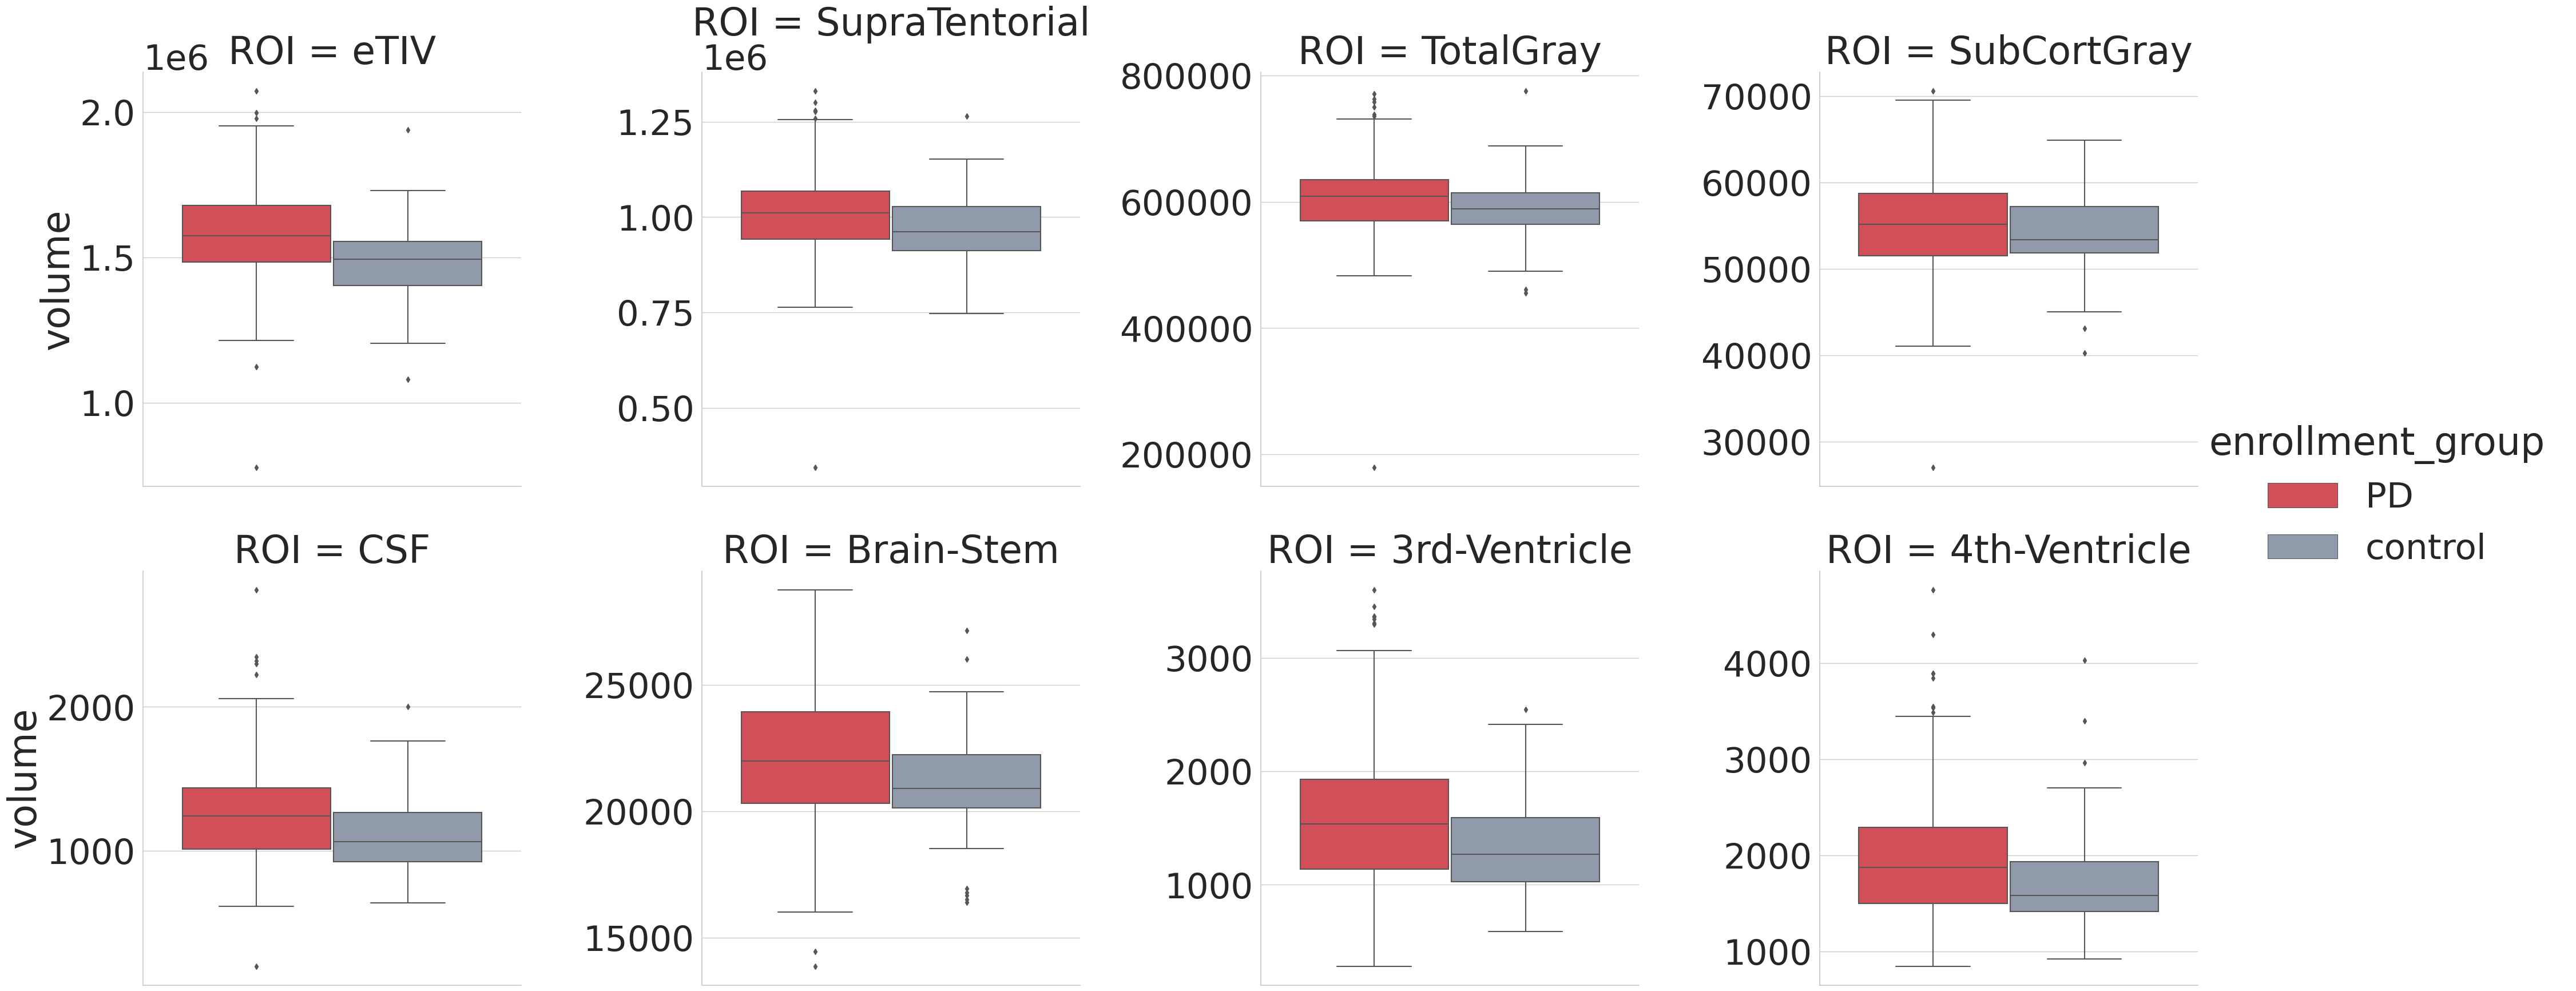

In [88]:
save_fig = False

# Rename global regions for brevity
plot_renaming_dict = {"EstimatedTotalIntraCranialVol":"eTIV"}
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=plot_renaming_dict)

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")
participants_per_group = plot_df.groupby([startification_col])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue=startification_col, col="ROI",kind="box", col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    g.set_xlabels("")
    g.set_xticklabels("")

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Save global aseg vols

In [89]:
save_agg_aseg_df = True

if save_agg_aseg_df:
    save_file = f"{save_dir}/global_vol_ASEG_df.csv"
    print(f"Saving aseg_DKT_df to {save_file}")
    global_vol_ASEG_df.to_csv(save_file, index=False)

global_vol_ASEG_df.head()

Saving aseg_DKT_df to /home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/qpn/Aug_2024/agg_dfs//global_vol_ASEG_df.csv


,3rd-Ventricle,4th-Ventricle,5th-Ventricle,Brain-Stem,BrainSeg,BrainSegNotVent,CC_Anterior,CC_Central,CC_Mid_Anterior,CC_Mid_Posterior,...,Cortex,CerebralWhiteMatter,Mask,MaskVol-to-eTIV,BrainSegVol-to-eTIV,SurfaceHoles,participant_id,sex,enrollment_group,hemi
0,1360.3,1787.4,0.0,25180.7,1268014.0,1241132.0,1322.0,531.8,648.6,684.7,...,470723.078926,565633.0,1561089.0,0.919697,0.747035,7,MNI0028,Male/Masculin,PD,global
1,2976.9,2691.0,0.0,20471.7,1250678.0,1160664.0,1011.1,445.4,491.8,466.4,...,468121.412514,515939.0,1599308.0,0.876686,0.685579,26,MNI0056,Male/Masculin,PD,global
2,1429.2,988.4,0.0,27453.5,1250635.0,1233803.0,768.3,756.6,578.4,523.3,...,491792.631716,549767.0,1603655.0,0.971572,0.757695,44,MNI0058,Male/Masculin,PD,global
3,1348.8,1599.4,0.0,20654.2,1063409.0,1037897.0,854.4,420.8,705.6,486.9,...,422490.746237,434460.0,1371644.0,0.915154,0.709501,11,MNI0068,Male/Masculin,PD,global
4,952.4,1449.5,0.0,21743.1,1144991.0,1131912.0,930.8,801.1,797.4,507.2,...,462559.995060,474975.0,1447415.0,0.941479,0.744766,15,MNI0079,Female/Féminin,PD,global
